# Model creation stage II (4x8)

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup

In [9]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tools import common_functions as cf
from tools import regression as reg
from tools import plotting_functions as pf

from tools import sensor_gui as sg

# Folder prefix with all the taxel data
TAXEL_DATA_FOLDER = f"table_calibration/taxel"


# Parameters
SENSOR_LAG = 80 # ms
ARRAY_SIZE = 32

# Automated
data_columns = [f'X{i}' for i in range(ARRAY_SIZE)] + [f'Y{i}' for i in range(ARRAY_SIZE)] + [f'Z{i}' for i in range(ARRAY_SIZE)]

In [10]:
taxels_data = []

for i in range(ARRAY_SIZE):
  
  # Load the data
  taxel_data = cf.prepare_data_for_fitting(f"{TAXEL_DATA_FOLDER}{i}", ARRAY_SIZE, SENSOR_LAG, rotation=90 + 1.82, faulty=False, cut_in_half=True)
  taxels_data.append(taxel_data)

Preparing data for fitting: table_calibration/taxel0
False True


/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:318: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= mean_without_outliers(data[col][:window])


Preparing data for fitting: table_calibration/taxel1
False True


/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:318: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= mean_without_outliers(data[col][:window])


Preparing data for fitting: table_calibration/taxel2
False True


/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:318: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= mean_without_outliers(data[col][:window])


Preparing data for fitting: table_calibration/taxel3
False True


/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:318: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= mean_without_outliers(data[col][:window])


Preparing data for fitting: table_calibration/taxel4
False True


/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:318: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= mean_without_outliers(data[col][:window])


Preparing data for fitting: table_calibration/taxel5
False True


/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:318: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= mean_without_outliers(data[col][:window])


Preparing data for fitting: table_calibration/taxel6
False True


/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:318: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= mean_without_outliers(data[col][:window])


Preparing data for fitting: table_calibration/taxel7
False True


/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:318: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= mean_without_outliers(data[col][:window])


Preparing data for fitting: table_calibration/taxel8
False True


/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:318: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= mean_without_outliers(data[col][:window])


Preparing data for fitting: table_calibration/taxel9
False True


/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:318: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= mean_without_outliers(data[col][:window])


Preparing data for fitting: table_calibration/taxel10
False True


/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:318: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= mean_without_outliers(data[col][:window])


Preparing data for fitting: table_calibration/taxel11
False True


/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:318: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= mean_without_outliers(data[col][:window])


Preparing data for fitting: table_calibration/taxel12
False True


/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:318: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= mean_without_outliers(data[col][:window])


Preparing data for fitting: table_calibration/taxel13
False True


/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:318: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= mean_without_outliers(data[col][:window])


Preparing data for fitting: table_calibration/taxel14
False True


/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:318: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= mean_without_outliers(data[col][:window])


Preparing data for fitting: table_calibration/taxel15
False True


/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:318: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= mean_without_outliers(data[col][:window])


Preparing data for fitting: table_calibration/taxel16
False True


/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:318: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= mean_without_outliers(data[col][:window])


Preparing data for fitting: table_calibration/taxel17
False True


/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:318: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= mean_without_outliers(data[col][:window])


Preparing data for fitting: table_calibration/taxel18
False True


/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:318: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= mean_without_outliers(data[col][:window])


Preparing data for fitting: table_calibration/taxel19
False True


/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:318: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= mean_without_outliers(data[col][:window])


Preparing data for fitting: table_calibration/taxel20
False True


/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:318: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= mean_without_outliers(data[col][:window])


Preparing data for fitting: table_calibration/taxel21
False True


/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:318: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= mean_without_outliers(data[col][:window])


Preparing data for fitting: table_calibration/taxel22
False True


/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:318: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= mean_without_outliers(data[col][:window])


Preparing data for fitting: table_calibration/taxel23
False True


/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:318: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= mean_without_outliers(data[col][:window])


Preparing data for fitting: table_calibration/taxel24
False True


/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:318: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= mean_without_outliers(data[col][:window])


Preparing data for fitting: table_calibration/taxel25
False True


/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:318: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= mean_without_outliers(data[col][:window])


Preparing data for fitting: table_calibration/taxel26
False True


/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:318: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= mean_without_outliers(data[col][:window])


Preparing data for fitting: table_calibration/taxel27
False True


/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:318: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= mean_without_outliers(data[col][:window])


Preparing data for fitting: table_calibration/taxel28
False True


/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:318: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= mean_without_outliers(data[col][:window])


Preparing data for fitting: table_calibration/taxel29
False True


/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:318: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= mean_without_outliers(data[col][:window])


Preparing data for fitting: table_calibration/taxel30
False True


/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:318: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= mean_without_outliers(data[col][:window])


Preparing data for fitting: table_calibration/taxel31
False True


/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:318: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= mean_without_outliers(data[col][:window])


In [11]:
# Load models from stage I
import os
import dill
    
save_path = os.path.join(os.getcwd(), '..', 'models', "4x8")
models = []
    
for i in range(ARRAY_SIZE):

    with open(os.path.join(save_path, f"taxel{i}"), 'rb') as f:
        model = dill.load(f)
        models.append(model)

with open(os.path.join(save_path, f"stageI"), 'rb') as f:
    stage_I_model = dill.load(f)        

# STAGE IIa

Linear model for crosstalk

In [12]:
# Represents the neighbours of every taxel (including itself)
neighbour_elements = []

def get_neighbors(x, y):
    neighbors = []
    for i in range(x - 1, x + 2):
        for j in range(y - 1, y + 2):
            neighbors.append((i, j))
    return neighbors

for i in range(8):
  for j in range(4):
    
    center_value = i * 4 + j
    
    neighbors = get_neighbors(i, j)
    neighbors_values = [n[0] * 4 + n[1] for n in neighbors]
    real_values = []
    
    for coord in neighbors:
      if coord[0] >= 0 and coord[1] >= 0 and coord[0] <= 7 and coord[1] <= 3:
        real_values.append(coord[0] * 4 + coord[1])
 
    neighbour_elements.append(real_values)

print(neighbour_elements)

[[0, 1, 4, 5], [0, 1, 2, 4, 5, 6], [1, 2, 3, 5, 6, 7], [2, 3, 6, 7], [0, 1, 4, 5, 8, 9], [0, 1, 2, 4, 5, 6, 8, 9, 10], [1, 2, 3, 5, 6, 7, 9, 10, 11], [2, 3, 6, 7, 10, 11], [4, 5, 8, 9, 12, 13], [4, 5, 6, 8, 9, 10, 12, 13, 14], [5, 6, 7, 9, 10, 11, 13, 14, 15], [6, 7, 10, 11, 14, 15], [8, 9, 12, 13, 16, 17], [8, 9, 10, 12, 13, 14, 16, 17, 18], [9, 10, 11, 13, 14, 15, 17, 18, 19], [10, 11, 14, 15, 18, 19], [12, 13, 16, 17, 20, 21], [12, 13, 14, 16, 17, 18, 20, 21, 22], [13, 14, 15, 17, 18, 19, 21, 22, 23], [14, 15, 18, 19, 22, 23], [16, 17, 20, 21, 24, 25], [16, 17, 18, 20, 21, 22, 24, 25, 26], [17, 18, 19, 21, 22, 23, 25, 26, 27], [18, 19, 22, 23, 26, 27], [20, 21, 24, 25, 28, 29], [20, 21, 22, 24, 25, 26, 28, 29, 30], [21, 22, 23, 25, 26, 27, 29, 30, 31], [22, 23, 26, 27, 30, 31], [24, 25, 28, 29], [24, 25, 26, 28, 29, 30], [25, 26, 27, 29, 30, 31], [26, 27, 30, 31]]


In [6]:
print("Prepping...")

all_forces = []
for i in range(ARRAY_SIZE):
  all_forces.append(stage_I_model.predict(taxels_data[i][1000:75000]))

Prepping...


# Linear

In [7]:
# Now we calculate the (non-zero) K_{i.j}'s as a 96x96 matrix
# K_{i,j}: influence of taxel i activation on taxel j (= the neighbour)
coefficients = np.zeros((32 * 3, 32 * 3))
bias = np.zeros((32 * 3))

print("Calculating K_{i,j}...")

cmodel = None

for i in range(ARRAY_SIZE):
  
  neighbours = neighbour_elements[i]
  
  for neighbour in neighbours:
    
    print(f"Creating K_{i, neighbour}...")

    X = all_forces[neighbour][neighbour]
    Y = all_forces[neighbour][i] 
    
    crosstalk_model = reg.create_regression_pipeline_and_fit(X, Y, debug=True, degree=1)[0]
    
    if neighbour == 1 and i == 0:
      cmodel = crosstalk_model
    
    coefficients[i * 3 : (i + 1) * 3, neighbour * 3 : (neighbour + 1) *  3] = crosstalk_model.steps[1][1].coef_[:, 1:]
    bias[i * 3 : (i + 1) * 3] = crosstalk_model.steps[1][1].coef_[:, 0]

Calculating K_{i,j}...
Creating K_(0, 0)...
Score:  1.0
MSE:  1.3964121927781665e-28
Creating K_(0, 1)...
Score:  0.9297497538195966
MSE:  0.0014984492531009358
Creating K_(0, 4)...
Score:  0.7064354631162925
MSE:  0.006738990808809214
Creating K_(0, 5)...
Score:  0.7689490280146224
MSE:  0.0008938912167803997
Creating K_(1, 0)...
Score:  0.7345529589051788
MSE:  0.03525300691624513
Creating K_(1, 1)...
Score:  1.0
MSE:  1.9313826008417703e-30
Creating K_(1, 2)...
Score:  0.8613838936933211
MSE:  0.06638808142740855
Creating K_(1, 4)...
Score:  0.6378153092856332
MSE:  0.0019544714293192027
Creating K_(1, 5)...
Score:  0.7775120786892963
MSE:  0.005298995158923171
Creating K_(1, 6)...
Score:  0.8477889178203339
MSE:  0.0004259929382240286
Creating K_(2, 1)...
Score:  0.8704682751349694
MSE:  0.001704651470516408
Creating K_(2, 2)...
Score:  1.0
MSE:  2.5977606602723707e-30
Creating K_(2, 3)...
Score:  0.891214165843626
MSE:  0.0018208301088076485
Creating K_(2, 5)...
Score:  0.52329392

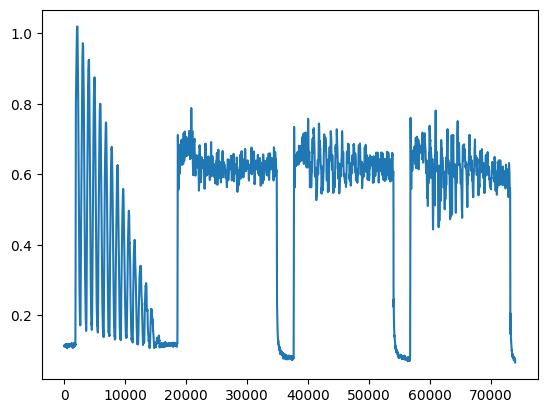

In [13]:
y_pred = cmodel.predict(all_forces[1][1])
plt.plot(y_pred[:,2])

In [14]:
M = np.linalg.inv(coefficients)

In [15]:
with np.printoptions(threshold=np.inf):
    print(coefficients)

[[ 1.00000000e+00 -2.61509564e-16  0.00000000e+00  3.18063562e-02
  -3.13060581e-02 -1.29922834e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -7.99813724e-02  6.02149620e-02 -2.44993866e-02  1.02302195e-02
   1.80953935e-02 -1.47601196e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000

In [16]:
with np.printoptions(threshold=np.inf):
    print(M)

[[ 1.00499545e+00  1.13730077e-02 -1.70187884e-03 -4.08236852e-02
   3.43860470e-02  1.28018545e-02 -2.06912004e-04 -1.44652229e-03
   6.97704859e-04 -6.28189194e-04  2.56217238e-05 -8.10486332e-05
   8.66107516e-02 -6.81232647e-02  2.76021059e-02 -1.40659172e-02
  -3.07595012e-02  1.09296959e-02 -2.85986508e-03  1.34671034e-02
   3.84948747e-04 -6.51788846e-04 -4.24651962e-03 -4.44276113e-04
   5.89928682e-03  5.95319310e-03 -1.26870295e-03 -2.29735054e-03
   7.40061494e-03  2.42808149e-04  1.81703399e-03  4.63889070e-03
   7.77827250e-05  7.52620783e-04 -3.66633253e-04  1.80092657e-04
   4.40640660e-04 -7.36107488e-04  2.36657217e-04 -3.36799471e-04
  -8.47717794e-04  5.02013754e-04  3.54894628e-04  2.41661803e-04
  -1.52594440e-04  9.16002337e-05 -1.37424359e-05  1.44170506e-05
  -3.74452127e-04 -1.51996688e-04  1.24100254e-04  2.55941174e-05
  -1.47371237e-05  4.49783058e-05 -3.38961630e-05  3.15369817e-05
   5.32959843e-05 -7.45001366e-07 -4.99489379e-06 -6.34239515e-06
   6.18162

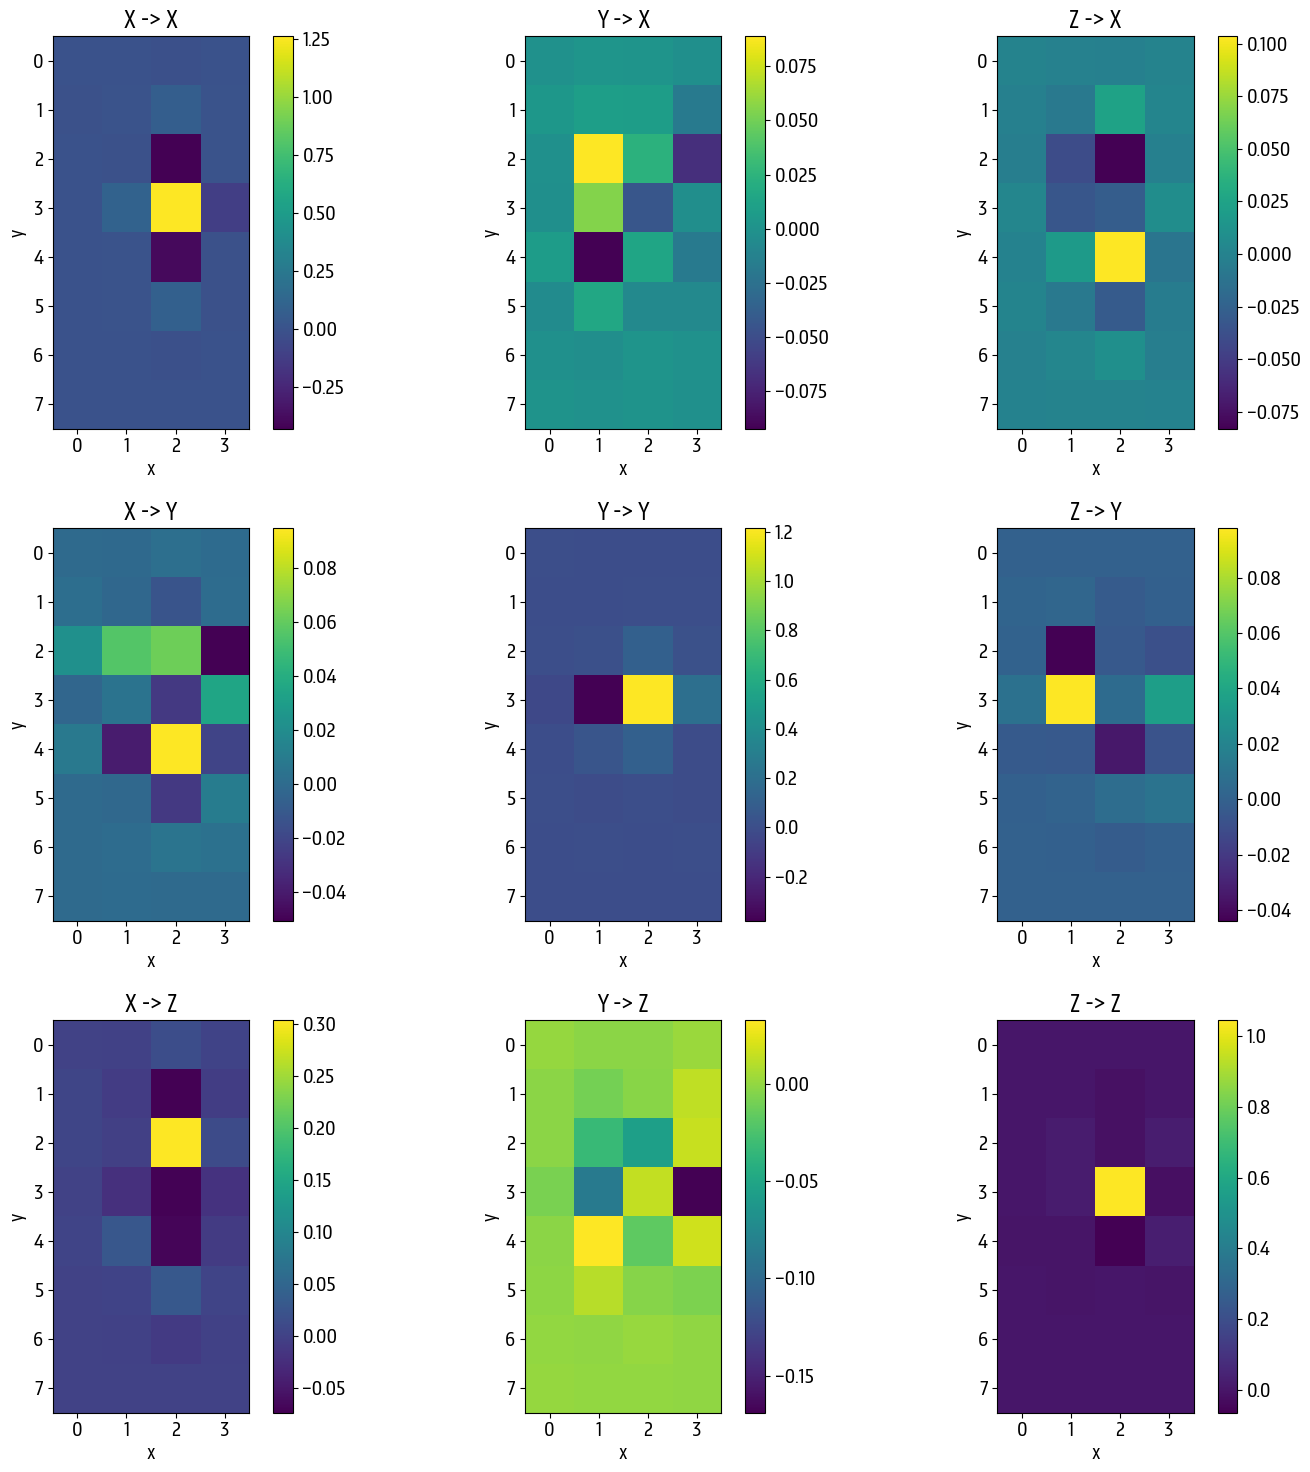

In [29]:
# Create a 2x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
plt.rcParams["font.family"] = "UGent Panno Text"
plt.rcParams["font.size"] = 16

components = [': X', ': Y', ': Z']

# M is (96, 96) matrix
# F_x1, F_y1, F_z1, F_x2, F_y2, F_z2, ..., F_x32, F_y32, F_z32


TAXEL_ID = 14
data_slice = M[TAXEL_ID * 3 : (TAXEL_ID + 1) * 3, :]
data_slice_G_x = data_slice[0, :]
data_slice_G_y = data_slice[1, :]
data_slice_G_z = data_slice[2, :]

for i, G_comp in enumerate(['X', 'Y', 'Z']):
    for j, F_comp in enumerate(['X', 'Y', 'Z']):
        ax = axes[i, j]
        data_slice_new = data_slice[i, j::3].reshape((8, 4))
        cax = ax.imshow(data_slice_new, cmap='viridis', interpolation='none')

        fig.colorbar(cax, ax=ax)  # Add colorbar to the current subplot
        ax.set_title(f'{F_comp} -> {G_comp}')  # Set the title for the current subplot

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        
        ax.set_xticks(np.arange(4))
        ax.set_yticks(np.arange(8))  
        
# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig("plots/c4_stageII_matrices.png", format="png", bbox_inches="tight")
plt.show()

In [18]:
print(bias.shape)

(96,)


In [19]:
class StageIIModel:
  def __init__(self, stage_I_model, M, bias) -> None:
    
    self.stage_I_model = stage_I_model
    self.M = M
    self.bias = bias
    
  def reshape_stage_2_input_vector(self, input_forces):
  
    nr_taxels, max_index, nr_features_per_taxel = input_forces.shape
    
    X = np.zeros((max_index, nr_taxels * nr_features_per_taxel))
    
    for k in range(nr_taxels):
      X[:, k * nr_features_per_taxel : (k+1) * nr_features_per_taxel] = input_forces[k]
      
    return X
    
  def predict(self, df):
    
    orig_forces = self.stage_I_model.predict(df)
    F = self.reshape_stage_2_input_vector(orig_forces).T - self.bias[:, None]
    G = self.M @ F
    
    return G.T, F.T
  
  def predict_single(self, X):
    
    orig_forces = self.stage_I_model.predict_single(X)
    F = self.reshape_stage_2_input_vector(orig_forces).T - self.bias[:, None]
    G = self.M @ F
    
    return G.T, F.T
  
stage_II_model = StageIIModel(stage_I_model, M, bias)

In [20]:
taxels_data[0][['F_x', 'F_y', 'F_z']].shape

(74133, 3)

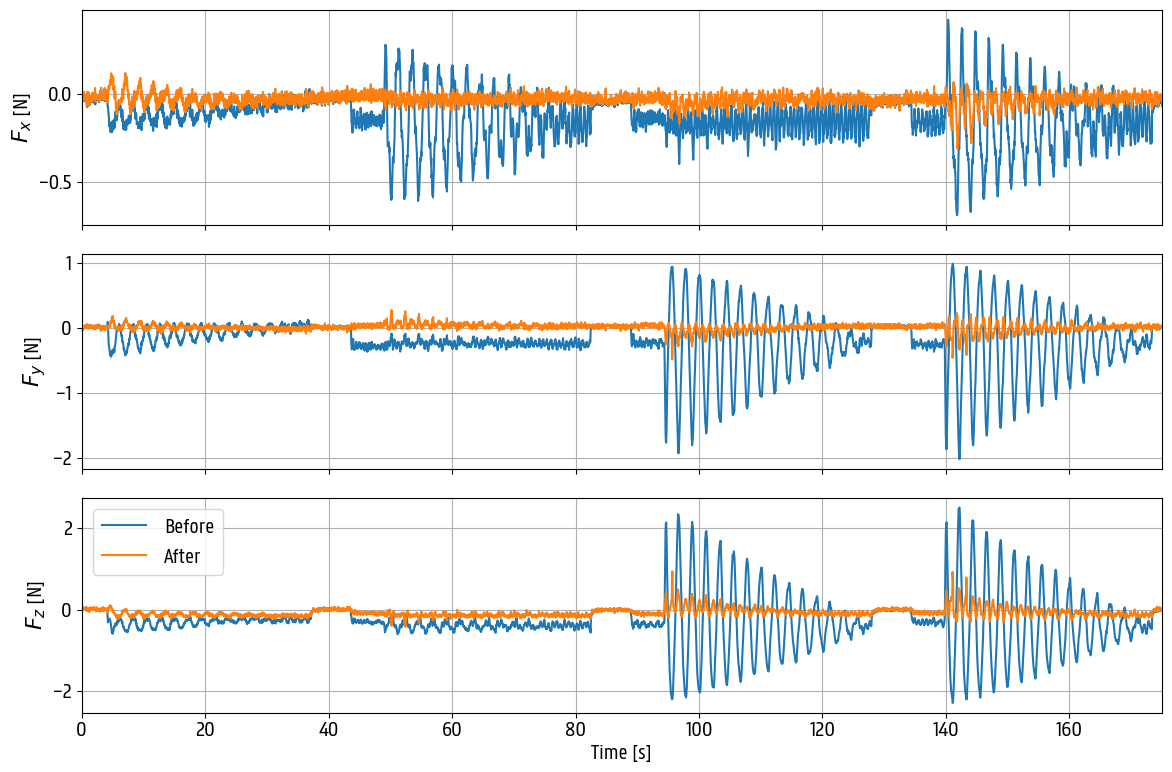

In [35]:
G, F_comp = stage_II_model.predict(taxels_data[14][1000:])

for i in [13]:
  
  fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
  t = np.linspace(0, 350/2, len(G))
  
  X, Y, Z = F_comp.T[i * 3: (i+1) * 3]
  
  axs[0].plot(t, X, label='Before')  
  axs[1].plot(t, Y, label='Before')  
  axs[2].plot(t, Z, label='Before')   

  X, Y, Z = G.T[i * 3: (i+1) * 3]
  
  axs[0].plot(t, X, label='After')  
  axs[0].set_ylabel('$F_x$ [N]') 
  axs[0].grid()
  
  axs[1].plot(t, Y, label='After')  
  axs[1].set_ylabel('$F_y$ [N]') 
  axs[1].grid()
  
  axs[2].plot(t, Z, label='After')    
  axs[2].set_ylabel('$F_z$ [N]') 
  axs[2].grid()

  plt.xlim([0, 350/2])
  plt.xlabel('Time [s]')
  
  plt.legend()
 
  plt.tight_layout()
  plt.savefig("plots/c4_s2_lin_ex.pdf", format="pdf", bbox_inches="tight")
  plt.show()

In [22]:
RMSEs_orig = []
RMSEs_after = []

RMSEs_origx = []
RMSEs_origy = []
RMSEs_origz = []

RMSEs_afterx = []
RMSEs_aftery = []
RMSEs_afterz = []

# Now calculate the NMSE for every dataset
for i in range(ARRAY_SIZE):
  
  print(f"Calculating NMSE for taxel {i}...")
  
  # Calculate the NMSE for every dataset
  Gall, F_compall = stage_II_model.predict(taxels_data[i][1000:75000])

  G = np.zeros_like(Gall)
  F_comp = np.zeros_like(F_compall)
  
  # Only calculate the RMSE on the neighbours of course  
  neighbours = neighbour_elements[i]
  for neighbour in neighbours:
    G[:, neighbour * 3 : (neighbour + 1) * 3] = Gall[:, neighbour * 3 : (neighbour + 1) * 3]
    F_comp[:, neighbour * 3 : (neighbour + 1) * 3] = F_compall[:, neighbour * 3 : (neighbour + 1) * 3]

  # Calculate Gref  
  Gref = np.zeros_like(G)
  Gref[:, i * 3 : (i + 1) * 3] = G[:, i * 3 : (i + 1) * 3]
  
  RMSE_orig = reg.calculate_RMSE(Gref, F_comp)
  RMSE_after = reg.calculate_RMSE(Gref, G)

  RMSEs_origx.append(reg.calculate_RMSE(Gref[:, ::3], F_comp[:, ::3]))
  RMSEs_origy.append(reg.calculate_RMSE(Gref[:, 1::3], F_comp[:, 1::3]))
  RMSEs_origz.append(reg.calculate_RMSE(Gref[:, 2::3], F_comp[:, 2::3]))
  
  RMSEs_afterx.append(reg.calculate_RMSE(Gref[:, ::3], G[:, ::3]))
  RMSEs_aftery.append(reg.calculate_RMSE(Gref[:, 1::3], G[:, 1::3]))
  RMSEs_afterz.append(reg.calculate_RMSE(Gref[:, 2::3], G[:, 2::3]))
  
  RMSEs_orig.append(RMSE_orig)
  RMSEs_after.append(RMSE_after)
  
  print(f"RMSE for taxel {i} : {RMSE_orig} -> {RMSE_after}")



Calculating NMSE for taxel 0...
RMSE for taxel 0 : 0.019861993767207233 -> 0.008596642414096113
Calculating NMSE for taxel 1...
RMSE for taxel 1 : 0.029933468629068084 -> 0.01341352786393159
Calculating NMSE for taxel 2...
RMSE for taxel 2 : 0.054442719019825246 -> 0.014791271775940843
Calculating NMSE for taxel 3...
RMSE for taxel 3 : 0.010805882025580778 -> 0.0038187336872164113
Calculating NMSE for taxel 4...
RMSE for taxel 4 : 0.051087556877901195 -> 0.03194033363686729
Calculating NMSE for taxel 5...
RMSE for taxel 5 : 0.043424178695975035 -> 0.015227344902213042
Calculating NMSE for taxel 6...
RMSE for taxel 6 : 0.051836139791573255 -> 0.014226576924419462
Calculating NMSE for taxel 7...
RMSE for taxel 7 : 0.027623917941042294 -> 0.009781717083457873
Calculating NMSE for taxel 8...
RMSE for taxel 8 : 0.06295208726157062 -> 0.016358622804977917
Calculating NMSE for taxel 9...
RMSE for taxel 9 : 0.06715958746568933 -> 0.015667404966413095
Calculating NMSE for taxel 10...
RMSE for t

In [23]:
print(f"{np.mean(RMSEs_orig):.6f}")
print(f"{np.mean(RMSEs_after):.6f}")
print("---")
print(f"{np.mean(RMSEs_origx):.5f}")
print(f"{np.mean(RMSEs_origy):.5f}")
print(f"{np.mean(RMSEs_origz):.5f}")
print("---")
print(f"{np.mean(RMSEs_afterx):.5f}")
print(f"{np.mean(RMSEs_aftery):.5f}")
print(f"{np.mean(RMSEs_afterz):.5f}")
print("===")
print(f"{np.std(RMSEs_orig):.5f}")
print(f"{np.std(RMSEs_after):.5f}")
print("---")
print(f"{np.std(RMSEs_origx):.5f}")
print(f"{np.std(RMSEs_origy):.5f}")
print(f"{np.std(RMSEs_origz):.5f}")
print("---")
print(f"{np.std(RMSEs_afterx):.5f}")
print(f"{np.std(RMSEs_aftery):.5f}")
print(f"{np.std(RMSEs_afterz):.5f}")


0.041153
0.013316
---
0.03858
0.03278
0.05210
---
0.01076
0.00982
0.01937
===
0.01431
0.00561
---
0.01745
0.01260
0.02053
---
0.00398
0.00473
0.01071


In [24]:
# Construct the latex table body
table_body = ""

for i in range(ARRAY_SIZE):
    table_body += f"Taxel {i} "

    table_body += f"& \multicolumn{{1}}{{l|}}{{{RMSEs_origx[i]:.5f}}} & \multicolumn{{1}}{{l|}}{{{RMSEs_origy[i]:.5f}}} & \multicolumn{{1}}{{l|}}{{{RMSEs_origz[i]:.5f}}} & {{{RMSEs_orig[i]:.5f}}} & \multicolumn{{1}}{{l|}}{{{RMSEs_afterx[i]:.5f}}} & \multicolumn{{1}}{{l|}}{{{RMSEs_aftery[i]:.5f}}} & \multicolumn{{1}}{{l|}}{{{RMSEs_afterz[i]:.5f}}} & {{{RMSEs_after[i]:.5f}}}"
    
    table_body += "\\\\ \hline \n"

print(table_body)

Taxel 0 & \multicolumn{1}{l|}{0.01991} & \multicolumn{1}{l|}{0.01349} & \multicolumn{1}{l|}{0.02619} & {0.01986} & \multicolumn{1}{l|}{0.00706} & \multicolumn{1}{l|}{0.00433} & \multicolumn{1}{l|}{0.01440} & {0.00860}\\ \hline 
Taxel 1 & \multicolumn{1}{l|}{0.03282} & \multicolumn{1}{l|}{0.02263} & \multicolumn{1}{l|}{0.03435} & {0.02993} & \multicolumn{1}{l|}{0.01747} & \multicolumn{1}{l|}{0.01311} & \multicolumn{1}{l|}{0.00966} & {0.01341}\\ \hline 
Taxel 2 & \multicolumn{1}{l|}{0.04570} & \multicolumn{1}{l|}{0.02097} & \multicolumn{1}{l|}{0.09666} & {0.05444} & \multicolumn{1}{l|}{0.01143} & \multicolumn{1}{l|}{0.00829} & \multicolumn{1}{l|}{0.02465} & {0.01479}\\ \hline 
Taxel 3 & \multicolumn{1}{l|}{0.00794} & \multicolumn{1}{l|}{0.01032} & \multicolumn{1}{l|}{0.01416} & {0.01081} & \multicolumn{1}{l|}{0.00220} & \multicolumn{1}{l|}{0.00286} & \multicolumn{1}{l|}{0.00640} & {0.00382}\\ \hline 
Taxel 4 & \multicolumn{1}{l|}{0.03224} & \multicolumn{1}{l|}{0.03999} & \multicolumn{1}{

In [30]:
# Save the model
reg.save_taxel_models(stage_II_model, "4x8", "stageII")

In [31]:
with open(os.path.join(save_path, f"stageII"), 'rb') as f:
    stage_II_model = dill.load(f)     

/tmp/ipykernel_69561/4211917220.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(taxels_data[0]['Z'][min_index:max_index], taxels_data[0]['F_z'][min_index:max_index], label='Z')


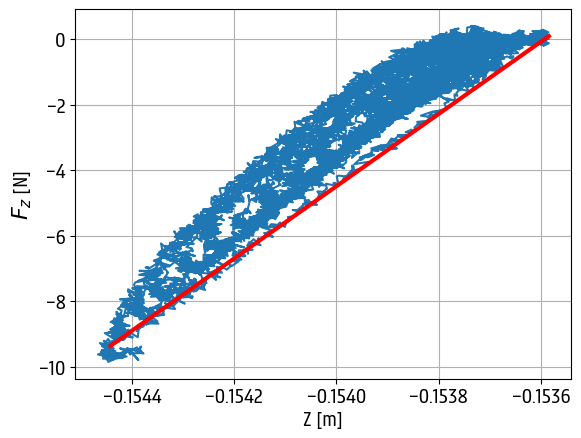

In [88]:
min_index = 3000
max_index = 2500 + 33 * 400

plt.plot(taxels_data[0]['Z'][min_index:max_index], taxels_data[0]['F_z'][min_index:max_index], label='Z')
plt.plot([taxels_data[0]['Z'][min_index+100], taxels_data[0]['Z'][max_index]], [taxels_data[0]['F_z'][min_index], taxels_data[0]['F_z'][max_index-100]], c='r', linewidth=3)
plt.grid()
plt.xlabel('Z [m]')
plt.ylabel('$F_z$ [N]')

plt.savefig("plots/c4_hyst_pos.pdf", format="pdf", bbox_inches="tight")

In [89]:
forces = stage_II_model.predict(taxels_data[0][min_index:max_index])[0]
forces.shape

(12700, 96)

/tmp/ipykernel_69561/3024686400.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(forces[:, 2], taxels_data[0]['F_z'][min_index:max_index], label='Z')


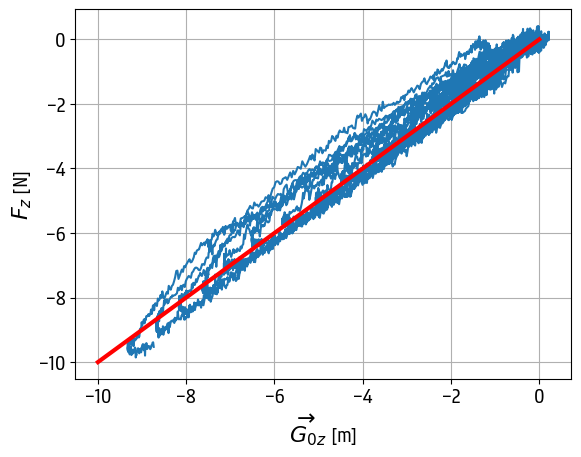

In [90]:
plt.plot(forces[:, 2], taxels_data[0]['F_z'][min_index:max_index], label='Z')
plt.plot([0, -10], [0, -10], c='r', linewidth=3)
plt.grid()
plt.xlabel('$\overrightarrow{G_0}_z$ [m]')
plt.ylabel('$F_z$ [N]')

plt.savefig("plots/c4_hyst_Z.pdf", format="pdf", bbox_inches="tight")

/tmp/ipykernel_69561/4249449352.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(taxels_data[0]['X'][59000:])


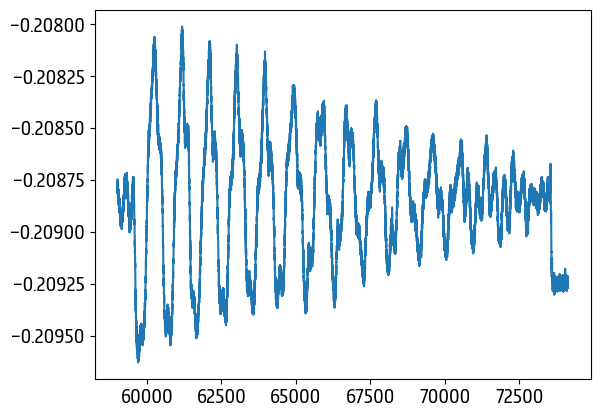

In [78]:
plt.plot(taxels_data[0]['X'][59000:])

/tmp/ipykernel_69561/2792444486.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(forces[:, 0], taxels_data[0]['F_x'][min_index:max_index], label='Z')


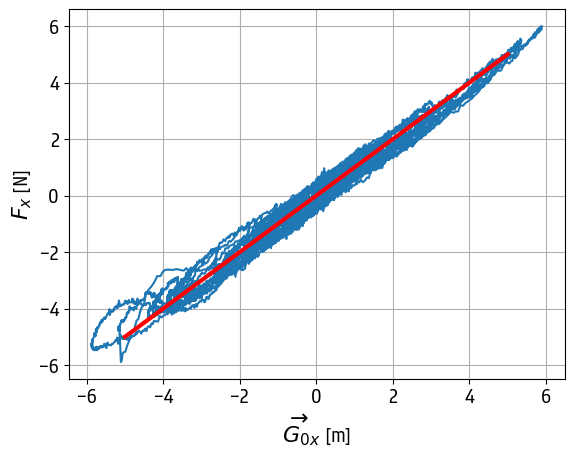

In [91]:
min_index = 59500
max_index = -1
forces = stage_II_model.predict(taxels_data[0][min_index:max_index])[0]
forces.shape
plt.plot(forces[:, 0], taxels_data[0]['F_x'][min_index:max_index], label='Z')
plt.plot([5, -5], [5, -5], c='r', linewidth=3)
plt.grid()
plt.xlabel('$\overrightarrow{G_0}_x$ [m]')
plt.ylabel('$F_x$ [N]')

plt.savefig("plots/c4_hyst_X.pdf", format="pdf", bbox_inches="tight")

/tmp/ipykernel_69561/2445609977.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(forces[:, 1], taxels_data[0]['F_y'][min_index:max_index], label='Z')


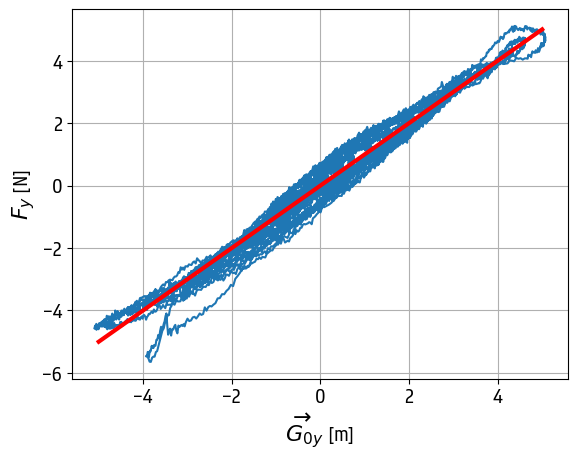

In [92]:
min_index = 59500
max_index = -1
forces = stage_II_model.predict(taxels_data[0][min_index:max_index])[0]
forces.shape
plt.plot(forces[:, 1], taxels_data[0]['F_y'][min_index:max_index], label='Z')
plt.plot([5, -5], [5, -5], c='r', linewidth=3)
plt.grid()
plt.xlabel('$\overrightarrow{G_0}_y$ [m]')
plt.ylabel('$F_y$ [N]')

plt.savefig("plots/c4_hyst_Y.pdf", format="pdf", bbox_inches="tight")

In [85]:

def descending_sine_wave(time, frequency, max_amplitude, phase_shift = 0, shifted=True):
    max_time = np.max(time)
    time_adjusted = time - max_time
    if shifted:
        y_values = max_amplitude / max_time / 2 * time * (np.sin(2 * np.pi * frequency * time_adjusted - np.pi/2 + phase_shift) + 1)
    else:
        y_values = max_amplitude / max_time * time * np.sin(2 * np.pi * frequency * time_adjusted - np.pi/2 + phase_shift)
        
    return y_values[::-1]
  
import numpy as np
def generate_xy_forces(frequency, max_force, length, sample_rate=200):
  force_rate = max_force / length

  time = np.linspace(0, abs(max_force) / force_rate, int(abs(max_force) / force_rate * sample_rate))  # Time values from 0 to 2 seconds

  x_force_values = descending_sine_wave(time, frequency, max_force, 0, False)
  y_force_values = descending_sine_wave(time, frequency, max_force, np.pi/2, False)
  
  return x_force_values, y_force_values

x_force_values, y_force_values = generate_xy_forces(0.5, 5, 30)

Text(0, 0.5, '$F_y$ [N]')

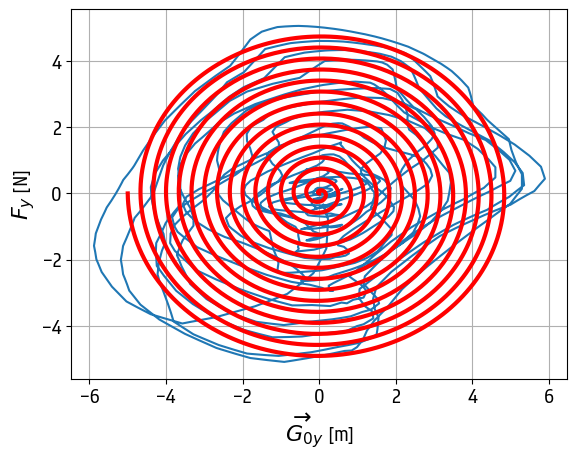

In [86]:
min_index = 59500
max_index = -1
forces = stage_II_model.predict(taxels_data[0][min_index:max_index])[0]
forces.shape
plt.plot(forces[:, 0], forces[:, 1], label='Z')
# plt.plot([5, -5], [5, -5], c='r', linewidth=3)
plt.plot(x_force_values, y_force_values, c='r', linewidth=3)
plt.grid()
plt.xlabel('$\overrightarrow{G_0}_y$ [m]')
plt.ylabel('$F_y$ [N]')